In [2]:

import os, builtins, io
import pandas as _pd
from contextlib import contextmanager

class ReadOnlyGuard:
    WRITE_TOKENS = ("w", "a", "x")
    # Capture true originals exactly once
    ORIG_OPEN = staticmethod(io.open)                    # real builtin open
    ORIG_TO_CSV = staticmethod(_pd.DataFrame.to_csv)     # original to_csv at import
    _refcount = 0                                        # class-level refcount

    def __init__(self, protected_dirs, allow_dirs=None):
        self.protected = [os.path.abspath(d) for d in protected_dirs]
        self.allow = [os.path.abspath(d) for d in (allow_dirs or [])]
        self._enabled = False

    def _in_ro_scope(self, p):
        if not p:
            return False
        ap = os.path.abspath(p)
        # allow-list takes precedence
        if any(ap == root or ap.startswith(root + os.sep) for root in self.allow):
            return False
        return any(ap == root or ap.startswith(root + os.sep) for root in self.protected)

    def enable(self):
        if self._enabled:
            ReadOnlyGuard._refcount += 1
            return

        def ro_open(file, mode="r", *a, **k):
            m = str(mode).lower()
            if any(t in m for t in self.WRITE_TOKENS) and self._in_ro_scope(file):
                raise PermissionError(f"ReadOnlyGuard blocked open('{file}', mode='{mode}')")
            return ReadOnlyGuard.ORIG_OPEN(file, mode, *a, **k)

        def ro_to_csv(self_df, path_or_buf=None, *a, **k):
            if isinstance(path_or_buf, (str, os.PathLike)) and self._in_ro_scope(path_or_buf):
                raise PermissionError(f"ReadOnlyGuard blocked to_csv('{path_or_buf}')")
            return ReadOnlyGuard.ORIG_TO_CSV(self_df, path_or_buf, *a, **k)

        builtins.open = ro_open
        _pd.DataFrame.to_csv = ro_to_csv
        self._enabled = True
        ReadOnlyGuard._refcount += 1

    def disable(self):
        if not self._enabled:
            return
        # Decrement and only restore when the last enabled guard disables
        ReadOnlyGuard._refcount -= 1
        if ReadOnlyGuard._refcount <= 0:
            builtins.open = ReadOnlyGuard.ORIG_OPEN
            _pd.DataFrame.to_csv = ReadOnlyGuard.ORIG_TO_CSV
            ReadOnlyGuard._refcount = 0
        self._enabled = False

    @contextmanager
    def temporarily_disabled(self):
        was_enabled = self._enabled
        if was_enabled:
            self.disable()
        else:
            # If some other guard instance enabled the patch, disable globally
            if ReadOnlyGuard._refcount > 0:
                # Disable one level (restore originals if this drops to zero)
                ReadOnlyGuard._refcount -= 1
                if ReadOnlyGuard._refcount == 0:
                    builtins.open = ReadOnlyGuard.ORIG_OPEN
                    _pd.DataFrame.to_csv = ReadOnlyGuard.ORIG_TO_CSV
        try:
            yield
        finally:
            # Restore to the exact prior state
            if was_enabled:
                self.enable()
            else:
                if ReadOnlyGuard._refcount == 0:
                    # Re-enable if others were active before we disabled one level
                    # (No-op if nobody else had it enabled)
                    pass




from cluster import Cluster
# global guard
# guard = ReadOnlyGuard([Cluster.BASE_PATH])
# guard.enable()
# os.environ["XSORTER_READONLY"] = "1"  # optional flag your code can check


ModuleNotFoundError: No module named 'cluster'

In [26]:
# --- Cell 2: viewer function ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_utils
from astropy.io import fits
from astropy.wcs import WCS
from scipy.stats import gaussian_kde
import astropy.units as u
from astropy.coordinates import SkyCoord



def plot_spatial_by_redshift_bins(
    cluster,
    z_bins,
    RA="RA",
    Dec="Dec",
    z="z",
    title=None,
    s=10,
    alpha=0.85,
    show=True,
    bandwidth=0.18,      # gaussian_kde bw_method (None='scott', or float, or 'silverman')
    gridsize=300,        # grid for contouring
    n_levels=8,          # number of contour levels
    linewidth=1.0
):
    """
    Plot sky distribution of galaxies in explicit redshift bins. Read-only by default.

    Parameters
    ----------
    cluster : Cluster
        Cluster object used only for paths/metadata; no files are modified.
    z_bins : list[tuple[float, float]]
        Redshift intervals to plot, e.g. [(0.515, 0.525), (0.525, 0.535)].
    ra_col, dec_col, z_col : str
        Column names in the combined redshift CSV.
    title : str
        Figure title; defaults to '<cluster.name> : Spatial Distribution by Redshift Bin'.
    s : float
        Marker size.
    alpha : float
        Marker alpha.
    show : bool
        If True, display the plot; otherwise return handles without showing.
    save_path : str or None
        Optional path to save the figure. If inside a protected directory,
        the read-only guard will block and raise (which is intended).

    Returns
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        Figure and axes for further customization.
    """
    fov = int(cluster.fov)
    fov=6
    ra_offset = cluster.ra_offset
    dec_offset = cluster.dec_offset

    optical_image_file = f"{cluster.photometry_path}/optical_image_{fov}_{ra_offset}_{dec_offset}.fits"

    with fits.open(optical_image_file) as hdul:
        optical_image_data = hdul[0].data
        wcs_optical = WCS(hdul[0].header, naxis=2)

    if not z_bins or not isinstance(z_bins, (list, tuple)):
        raise ValueError("Provide explicit 'z_bins' as a list of (zmin, zmax) tuples.")

    redshift_csv = cluster.spec_file
    df = pd.read_csv(redshift_csv)

    # Basic column checks
    missing = [c for c in (RA, Dec, z) if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in {os.path.basename(redshift_csv)}: {missing}")

    d = df[[RA, Dec, z]].dropna()
    if d.empty:
        raise ValueError("Redshift table is empty after dropping NaNs.")

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection=wcs_optical)


    # Load BCGs
    df = pd.read_csv(cluster.bcg_file)
    bcg_colors = ['black', 'tab:green',  'tab:purple', 'tab:cyan', 'tab:pink', 'gold', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']
    bcg_labels = ['A', 'B', 'C', 'D', 'E', 'F']

     # --- Figure/Axes ---
    legend_handles = []

    for i, row in df.iterrows():
        ra = float(row['RA'])
        dec = float(row['Dec'])
        z_bcg = row['z'] if not pd.isnull(row['z']) else None
        
        color = bcg_colors[i % len(bcg_colors)]
        if i < 5:
            label = f"BCG {i+1} (z = {'unknown' if z_bcg is None else f'{z_bcg:.3f}'})"
            marker = '*'
        else:
            label = f"BCG {bcg_labels[i-5]} (z = {'unknown' if z_bcg is None else f'{z_bcg:.3f}'})"
            marker = 'o'
        
        # Plot
        sc = ax.scatter(ra, dec, marker=marker, edgecolor=color, facecolor='none', s=220, zorder=10,
                        transform=ax.get_transform('icrs'), label=label)
        # For manual legend

        legend_handles.append(sc)

    colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])
    colors = ['tab:green', 'tab:pink', 'tab:blue']

    # Use the default color cycle
    for i, (zmin, zmax) in enumerate(z_bins):
        mask = (d[z] >= zmin) & (d[z] < zmax)
        if not mask.any():
            continue
        # ax.scatter(
        #     d.loc[mask, RA].values,
        #     d.loc[mask, Dec].values,
        #     s=s, alpha=alpha, color=colors[i % len(colors)], transform=ax.get_transform('icrs'), label=f"{zmin:.4f} <= z < {zmax:.4f}",
        # )


        # --- Per-bin KDE contours ---
    from matplotlib.lines import Line2D

    ra0, dec0 = float(np.median(d[RA])), float(np.median(d[Dec]))
    cosd0 = np.cos(np.deg2rad(dec0))

    # small-angle offsets (degrees)
    x = (d[RA] - ra0) * cosd0
    y = (d[Dec] - dec0)


    # Build KDE and evaluation grid (world coords)
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method=bandwidth)

    x_grid = np.linspace(x.min(), x.max(), int(gridsize))
    y_grid = np.linspace(y.min(), y.max(), int(gridsize))
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid, indexing="xy")

    # Convert mesh grid back to RA/Dec
    ra_mesh = x_mesh / cosd0 + ra0
    dec_mesh = y_mesh + dec0

    for i, (zmin, zmax) in enumerate(z_bins):
        mask = (d[z] >= zmin) & (d[z] < zmax)
        if not mask.any():
            continue

        ra = d.loc[mask, RA].to_numpy()
        dec = d.loc[mask, Dec].to_numpy()
        # small-angle offsets (degrees)
        x = (ra - ra0) * cosd0
        y = (dec - dec0)


        # Build KDE and evaluation grid (world coords)
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy, bw_method=bandwidth)

        dens = kde(np.vstack([(x_mesh).ravel(), (y_mesh).ravel()])).reshape(ra_mesh.shape)
        if not np.isfinite(dens).any():
            continue

        # Evenly spaced contour levels between min and max (skip the absolute min)
        dmin, dmax = np.nanmin(dens), np.nanmax(dens)
        if not np.isfinite(dmin) or not np.isfinite(dmax) or dmax <= dmin:
            continue
        levels = np.linspace(dmin, dmax, int(max(2, n_levels)) + 1)[1:]

        color = colors[i % len(colors)]
        ax.contour(
            ra_mesh,
            dec_mesh,
            dens,
            levels=levels,
            colors=[color],
            linewidths=linewidth,
            alpha=alpha,
            transform=ax.get_transform('icrs'),
        )

        legend_handles.append(
            Line2D([0], [0], color=color, lw=1.2, label=f"{zmin:.3f} < z < {zmax:.3f}")
        )


    img = np.transpose(optical_image_data, (1, 2, 0)) if optical_image_data.ndim == 3 else optical_image_data


    if img.dtype.kind == 'f':
        img[...] = 1.0
    else:
        img[...] = 255

    # my_utils.add_xray_contours(ax, cluster.xray_file, img, wcs_optical)
    ax.set_xlabel("R.A.")
    ax.set_xlim(d[RA].max(), d[RA].min()) 
    ax.set_ylabel("Decl.")
    # Compute RA/Dec bounds from your data
    ra_min, ra_max = d["RA"].min(), d["RA"].max()
    dec_min, dec_max = d["Dec"].min(), d["Dec"].max()

    # Build SkyCoord objects
    corners = SkyCoord(
        [ra_min, ra_max]*u.deg,
        [dec_min, dec_max]*u.deg,
        frame="icrs"
    )

    # Convert to pixel coordinates
    x_pix, y_pix = wcs_optical.world_to_pixel(corners)

    # Apply axis limits in pixel space
    ax.set_xlim(x_pix[1], x_pix[0])   # reverse RA so east is left
    ax.set_ylim(y_pix[0], y_pix[1])   # Dec increases upward

    ax.legend(handles=legend_handles, frameon=True, loc="best", fontsize=10)

    if show:
        plt.show()
    else:
        with guard.temporarily_disabled():
            print("Saving figure...")
            save_file = f"{cluster.image_path}/{cluster.identifier.replace(' ', '_')}_foregrounds.pdf"
            fig.savefig(save_file, dpi=450, bbox_inches="tight")

    return fig, ax


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

# add this import near the top of your file
from scipy.stats import gaussian_kde


def plot_spatial_by_redshift_bins_density_kde(
    cluster,
    z_bins,
    RA="RA",
    Dec="Dec",
    z="z",
    title=None,
    bandwidth=0.1,      # gaussian_kde bw_method (None='scott', or float, or 'silverman')
    gridsize=300,        # grid for contouring
    n_levels=8,          # number of contour levels
    linewidth=1.0,
    alpha=0.9,
    show=True,
):
    """
    Plot sky distribution of galaxies in explicit redshift bins as KDE density contours.

    Parameters
    ----------
    cluster : Cluster
        Cluster object used only for paths/metadata; no files are modified.
    z_bins : list[tuple[float, float]]
        Redshift intervals to plot, e.g. [(0.515, 0.525), (0.525, 0.535)].
    RA, Dec, z : str
        Column names in the combined redshift CSV.
    title : str or None
        Title; defaults to '<cluster.identifier> : Spatial Density by Redshift Bin'.
    bandwidth : None | float | str | callable
        Passed to gaussian_kde as bw_method. None uses 'scott'.
    gridsize : int
        Resolution of the evaluation grid in each dimension.
    n_levels : int
        Number of contour levels (evenly spaced between min and max density).
    linewidth : float
        Contour line width.
    alpha : float
        Contour alpha.
    show : bool
        If True, display the plot; otherwise close and return fig, ax.

    Returns
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        Figure and axes for further customization.
    """
    # --- WCS from your optical reference frame ---
    fov = int(cluster.fov)
    ra_offset = cluster.ra_offset
    dec_offset = cluster.dec_offset
    optical_image_file = f"{cluster.photometry_path}/optical_image_{fov}_{ra_offset}_{dec_offset}.fits"
    with fits.open(optical_image_file) as hdul:
        optical_image_data = hdul[0].data
        wcs_optical = WCS(hdul[0].header, naxis=2)

    if not z_bins or not isinstance(z_bins, (list, tuple)):
        raise ValueError("Provide explicit 'z_bins' as a list of (zmin, zmax) tuples.")

    # --- Load table and basic checks ---
    redshift_csv = cluster.spec_file
    df = pd.read_csv(redshift_csv)
    missing = [c for c in (RA, Dec, z) if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in {os.path.basename(redshift_csv)}: {missing}")
    d = df[[RA, Dec, z]].dropna()
    if d.empty:
        raise ValueError("Redshift table is empty after dropping NaNs.")


    # Load BCGs
    df = pd.read_csv(cluster.bcg_file)
    bcg_colors = ['black', 'tab:green',  'tab:purple', 'tab:cyan', 'tab:pink', 'gold', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']
    bcg_labels = ['A', 'B', 'C', 'D', 'E', 'F']

     # --- Figure/Axes ---
    fig = plt.figure(figsize=(7.5, 7.0))
    ax = fig.add_subplot(111, projection=wcs_optical)
    legend_handles = []

    img = np.transpose(optical_image_data, (1, 2, 0)) if optical_image_data.ndim == 3 else optical_image_data


    if img.dtype.kind == 'f':
        img[...] = 1.0
    else:
        img[...] = 255

    ax.imshow(img, origin='lower')

    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

    for i, row in df.iterrows():
        ra = float(row['RA'])
        dec = float(row['Dec'])
        z_bcg = row['z'] if not pd.isnull(row['z']) else None
        
        color = bcg_colors[i % len(bcg_colors)]
        if i < 5:
            label = f"BCG {i+1} (z = {'unknown' if z_bcg is None else f'{z_bcg:.3f}'})"
            marker = '*'
        else:
            label = f"BCG {bcg_labels[i-5]} (z = {'unknown' if z_bcg is None else f'{z_bcg:.3f}'})"
            marker = 'o'
        
        # Plot
        sc = ax.scatter(ra, dec, marker=marker, edgecolor=color, facecolor='none', s=200,
                        transform=ax.get_transform('icrs'), label=label)
        # For manual legend

        legend_handles.append(sc)
    
    





    colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])



    # my_utils.add_xray_contours(ax, cluster.xray_file, img, wcs_optical)


    # --- Per-bin KDE contours ---
    from matplotlib.lines import Line2D
    contour_colors = ['black', 'tab:green', 'tab:pink', 'tab:blue', 'tab:orange', 'tab:purple']
    for i, (zmin, zmax) in enumerate(z_bins):
        mask = (d[z] >= zmin) & (d[z] < zmax)
        if not mask.any():
            continue

        ra = d.loc[mask, RA].to_numpy()
        dec = d.loc[mask, Dec].to_numpy()

        # Need at least 2 unique points for KDE
        if np.unique(ra).size < 2 or np.unique(dec).size < 2 or ra.size < 3:
            # not enough points for a meaningful KDE; skip quietly
            continue

        # Build KDE and evaluation grid (world coords)
        xy = np.vstack([ra, dec])
        kde = gaussian_kde(xy, bw_method=bandwidth)

        ra_grid = np.linspace(ra.min(), ra.max(), int(gridsize))
        dec_grid = np.linspace(dec.min(), dec.max(), int(gridsize))
        ra_mesh, dec_mesh = np.meshgrid(ra_grid, dec_grid, indexing="xy")

        dens = kde(np.vstack([ra_mesh.ravel(), dec_mesh.ravel()])).reshape(ra_mesh.shape)
        if not np.isfinite(dens).any():
            continue

        # Evenly spaced contour levels between min and max (skip the absolute min)
        dmin, dmax = np.nanmin(dens), np.nanmax(dens)
        if not np.isfinite(dmin) or not np.isfinite(dmax) or dmax <= dmin:
            continue
        levels = np.linspace(dmin, dmax, int(max(2, n_levels)) + 1)[1:]

        # color = colors[i % len(colors)]
        color = contour_colors[i % len(contour_colors)]
        ax.contour(
            ra_mesh,
            dec_mesh,
            dens,
            levels=levels,
            colors=[color],
            linewidths=linewidth,
            alpha=alpha,
            transform=ax.get_transform('icrs'),
        )

        legend_handles.append(
            Line2D([0], [0], color=color, lw=1.0, label=f"{zmin:.3f} < z < {zmax:.3f}")
        )

    # --- Labels and legend ---
    ax.set_xlabel("R.A.")
    ax.set_ylabel("Decl.")
    ttl = title or f"{cluster.identifier} : Spatial Density by Redshift Bin"
    # ax.set_title(ttl)
    if legend_handles:
        ax.legend(handles=legend_handles, frameon=True, loc="best", fontsize=10)


    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax


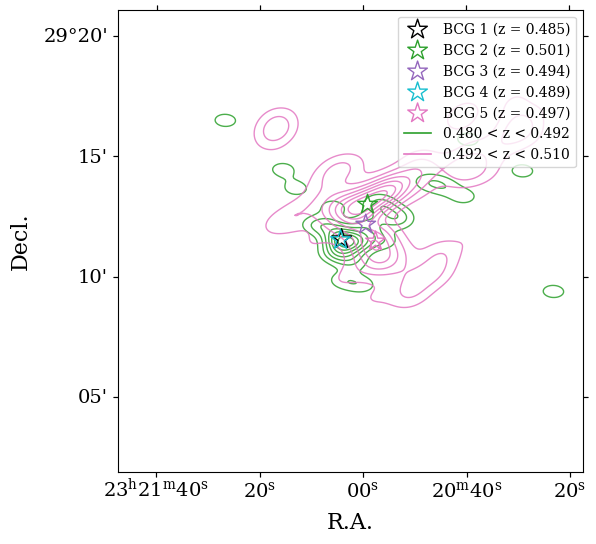

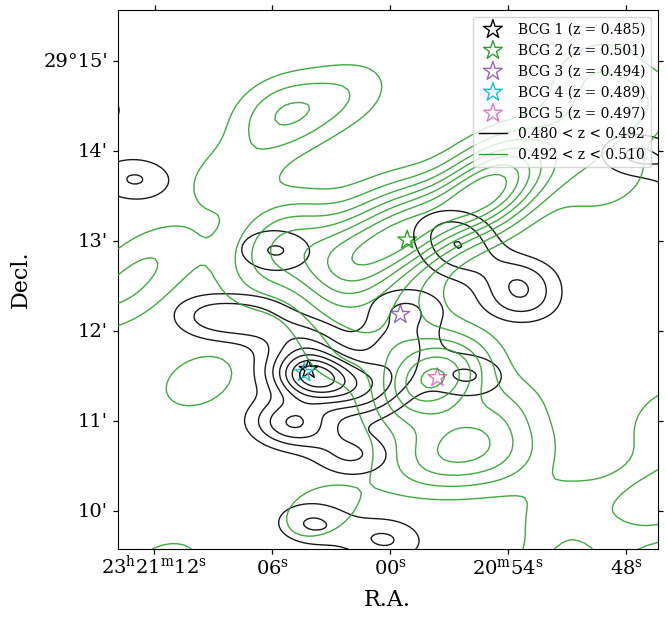

(<Figure size 750x700 with 1 Axes>, <WCSAxes: >)

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

cluster = Cluster("RMJ 1043")
cluster.populate(update=False)

# z_slices = [(0.42, 0.44), (0.44, 0.48), (0.53, 0.58)]
# z_slices = [(0.41, 0.425), (0.425, 0.44), (0.45, 0.48)]
# z_slices = [(0.378, 0.4), (0.46, 0.484), (0.535, 0.566)]
# z_slices = [(0.515, 0.54), (0.475, 0.515),  (0.45, 0.475)]
# z_slices = [(0.48, 0.492), (0.492, 0.51)]
z_slices = [(0.4, 0.425), (0.425, 0.438), (0.438, 0.468)]
plot_spatial_by_redshift_bins(cluster=cluster, z_bins=z_slices, show=True)  # no writes
plot_spatial_by_redshift_bins_density_kde(cluster=cluster, z_bins=z_slices, bandwidth=0.11, show=True)

In [1]:
def calc_vel_differenc(z1, z2):
    from astropy.constants import c
    c_kms = c.to_value('km/s')
    z_mean = (z1 + z2) / 2
    delta_v = c_kms * (z2 - z1) / (1 + z_mean)
    return delta_v

from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy import units as u
import numpy as np

def los_distance_difference(z1, z2, cosmo=cosmo, return_proper=True,
                            sig_z1=None, sig_z2=None, use_approx=False):
    """
    Line-of-sight distance difference if all Δz is attributed to distance (Hubble flow).

    Parameters
    ----------
    z1, z2 : float
        Redshifts to compare.
    cosmo : astropy.cosmology instance
        Cosmology to use. [default: Planck18]
    return_proper : bool
        If True, also return proper-at-epoch separation using (1+z_mean) scaling.
    sig_z1, sig_z2 : float, optional
        1-sigma redshift uncertainties for uncertainty propagation.
    use_approx : bool
        If True, use Δχ ≈ c Δz / H(z_mean) instead of exact distances.

    Returns
    -------
    out : dict
        {
          'z_mean': float,
          'dchi_Mpc': float,                 # comoving LOS separation [Mpc]
          'dchi_err_Mpc': float or None,     # optional
          'dproper_Mpc': float or None,      # proper-at-epoch (if return_proper)
          'dproper_err_Mpc': float or None   # optional
        }
    """
    z_mean = 0.5 * (z1 + z2)
    dz = z2 - z1

    if use_approx:
        Hz = cosmo.H(z_mean).to_value(u.km/u.s/u.Mpc)
        c_kms = (u.c.to(u.km/u.s)).value
        dchi = c_kms * dz / Hz  # Mpc
        dchi_err = None
        if (sig_z1 is not None) and (sig_z2 is not None):
            dz_err = np.hypot(sig_z1, sig_z2)
            dchi_err = c_kms * dz_err / Hz
    else:
        d2 = cosmo.comoving_distance(z2).to_value(u.Mpc)
        d1 = cosmo.comoving_distance(z1).to_value(u.Mpc)
        dchi = d2 - d1
        # For small Δz, propagate with derivative at z_mean:
        dchi_err = None
        if (sig_z1 is not None) and (sig_z2 is not None):
            Hz = cosmo.H(z_mean).to_value(u.km/u.s/u.Mpc)
            c_kms = (u.c.to(u.km/u.s)).value
            dz_err = np.hypot(sig_z1, sig_z2)
            dchi_err = c_kms * dz_err / Hz

    out = {'z_mean': z_mean, 'dchi_Mpc': dchi, 'dchi_err_Mpc': dchi_err}

    if return_proper:
        dproper = dchi / (1.0 + z_mean)
        dproper_err = (None if dchi_err is None else dchi_err / (1.0 + z_mean))
        out.update({'dproper_Mpc': dproper, 'dproper_err_Mpc': dproper_err})

    return out


z1 = 0.4298
z2 = 0.42173

print(calc_vel_differenc(z1, z2))
print(los_distance_difference(z1, z2))

-1696.8610788313688
{'z_mean': 0.425765, 'dchi_Mpc': np.float64(-27.58779670791114), 'dchi_err_Mpc': None, 'dproper_Mpc': np.float64(-19.349469728820065), 'dproper_err_Mpc': None}


In [16]:
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, Planck18
import astropy.units as u

def projected_sep_kpc_astropy(ra1_deg, dec1_deg, ra2_deg, dec2_deg, z):
    """
    Projected physical separation between two sky positions at redshift z.

    Parameters
    ----------
    ra1_deg, dec1_deg, ra2_deg, dec2_deg : float
        Right ascension and declination in decimal degrees.
    z : float
        Redshift at which to compute the proper (projected) separation.

    Returns
    -------
    ang_sep : Quantity
        Angular separation in arcsec.
    scale : Quantity
        Angular scale in kpc/arcsec at redshift z.
    proj_sep : Quantity
        Projected proper separation in kpc.
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    c1 = SkyCoord(ra1_deg * u.deg, dec1_deg * u.deg, frame="icrs")
    c2 = SkyCoord(ra2_deg * u.deg, dec2_deg * u.deg, frame="icrs")

    ang = c1.separation(c2)  # with units
    kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(z)  # kpc / arcmin

    # Let astropy do the conversion: arcsec -> arcmin (no manual /60)
    proj_kpc = (ang.to(u.arcmin) * kpc_per_arcmin).to(u.kpc)
    kpc_per_arcsec = (kpc_per_arcmin).to(u.kpc / u.arcsec)

    return ang.to(u.arcsec), kpc_per_arcsec, proj_kpc


ra1, dec1 = 141.69696, 5.00110
# ra2, dec2 = 141.69760, 5.01306
ra2, dec2 = 141.69397, 5.02389

# ra1, dec1 = 194.330834, 36.9140887
# ra2, dec2 = 194.339934, 36.9139869
# ra1, dec1 = 194.3366, 36.90151
# ra2, dec2 = 194.34135, 36.91943
# ra1, dec1 = 184.83333, 50.883333
# ra2, dec2 = 184.75687, 50.90707
ra1, dec1 = 201.85063, 53.78235
ra2, dec2 = 201.73846, 53.81966

z = 0.40

ang, scale, proj = projected_sep_kpc_astropy(ra1, dec1, ra2, dec2, z)
print(f"Angular separation: {ang:.3f}")
print(f"Scale at z={z}: {scale:.3f}")
print(f"Projected separation: {proj:.1f}")


Angular separation: 273.710 arcsec
Scale at z=0.4: 5.373 kpc / arcsec
Projected separation: 1470.6 kpc
